# Учебный EDA проект

Цель проекта: провести разведывательный анализ данных представленного датасета

Задачи проекта: 
- провести первичную обработку
- посмотреть распределение признаков для числовых переменных и устранить выбросы
- оценить количество уникальных значений для номинативных переменных
- провести корреляционный анализ количественных переменных
- провести анализ влияния наминативных переменных на предсказываемую величину 
- провести отбор признаков

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

pd.set_option('display.max_rows', 50) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок

In [2]:
# Загрузим данные и посмотрим их

df = pd.read_csv('stud_math.csv')
display(df.info())
display(df.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
school                 395 non-null object
sex                    395 non-null object
age                    395 non-null int64
address                378 non-null object
famsize                368 non-null object
Pstatus                350 non-null object
Medu                   392 non-null float64
Fedu                   371 non-null float64
Mjob                   376 non-null object
Fjob                   359 non-null object
reason                 378 non-null object
guardian               364 non-null object
traveltime             367 non-null float64
studytime              388 non-null float64
failures               373 non-null float64
schoolsup              386 non-null object
famsup                 356 non-null object
paid                   355 non-null object
activities             381 non-null object
nursery                379 non-null object
studytime, granular    388 non-

None

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0


In [3]:
# Посмотрим сколько всего колонок с пропущенными данными есть в датасете
df.isnull().any().sum()

27

Итак, посмотрим все данные отдельно.

In [4]:
# Аббревиатура школы, в которой учится ученик

print(df['school'].unique())
print(df['school'].value_counts(normalize=True))
print(df['school'].isnull().sum())

['GP' 'MS']
GP    0.883544
MS    0.116456
Name: school, dtype: float64
0


In [5]:
# 88% учеников в датасете представляют школу GP, оставшиеся - MS. Значений в столбце всего два, пропусков нет.
# По данным все ок. Так как значений в столбце всего два, можно безболезненно перевести их в числовой вид

school_dict = {'GP':1, 'MS':0}
df['school'] = df['school'].map(school_dict)

In [6]:
# Пол ученика

print(df['sex'].unique())
print(df['sex'].value_counts(normalize=True))
print(df['sex'].isnull().sum())

['F' 'M']
F    0.526582
M    0.473418
Name: sex, dtype: float64
0


In [7]:
# Тут тоже все ок. Недостающих значений нет. мальчиков и девочек почти поровну.
# Переведем значения в числовые

sex_dict = {'M':1, 'F':0}
df['sex'] = df['sex'].map(sex_dict)
print(type(df['sex'][0]))

<class 'numpy.int64'>


[18 17 15 16 19 22 20 21]
16    0.263291
17    0.248101
18    0.207595
15    0.207595
19    0.060759
20    0.007595
22    0.002532
21    0.002532
Name: age, dtype: float64
0


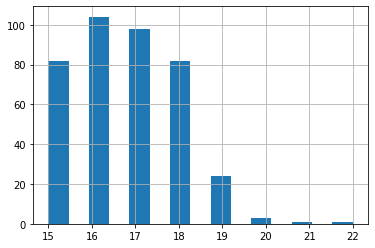

In [8]:
# Возраст ученика

print(df['age'].unique())
print(df['age'].value_counts(normalize=True))
df['age'].hist(bins=15)
print(df['age'].isnull().sum())

Как видно из данных, более 92% учеников относятся к возрасту 15-18. Возможно эти данные как-то коррелируют с 
распределением по школам.

In [9]:
# Тип адреса ученика ('U' - городской, 'R' - за городом)

print(df['address'].unique())
print(df['address'].value_counts(normalize=True))
df['address'].isnull().sum()

['U' nan 'R']
U    0.780423
R    0.219577
Name: address, dtype: float64


17

In [10]:
# Видим распределение примерно 80 / 20. Плюс здесь есть пропущенные значения.
# Возможно, эти данные коррелируют с данными по возрастам и школам.
# Переведем значения в числовые

addres_dict = {'U':1, 'R':0}
df['address'] = df['address'].map(addres_dict)
print(type(df['address'][0]))

<class 'numpy.float64'>


In [11]:
#  Размер семьи('LE3' <= 3, 'GT3' >3)

print(df['famsize'].unique())
print(df['famsize'].value_counts(normalize=True))
df['famsize'].isnull().sum()

[nan 'GT3' 'LE3']
GT3    0.709239
LE3    0.290761
Name: famsize, dtype: float64


27

In [12]:
# Здесь снова только два значения, которы распределены в соотношении примерно 70/30, плюс есть 27 пропусков. 
# Переведем признак из номинального в числовой

famsize_dict = {'GT3':1, 'LE3':0}
df['famsize'] = df['famsize'].map(famsize_dict)
print(type(df['famsize'][0]))

<class 'numpy.float64'>


In [13]:
# Статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)

print(df['Pstatus'].unique())
print(df['Pstatus'].value_counts(normalize=True))
df['Pstatus'].isnull().sum()

['A' nan 'T']
T    0.897143
A    0.102857
Name: Pstatus, dtype: float64


45

In [14]:
# Два значения признака, распередление 90 / 10. Одноко пропусков в данном столбце уже прям много - почти 1/6 от 
# датафрейма
# Переведем признак из номинального в числовой

Pstatus_dict = {'T':1, 'A':0}
df['Pstatus'] = df['Pstatus'].map(Pstatus_dict)
print(type(df['Pstatus'][0]))

<class 'numpy.float64'>


[ 4.  1.  3.  2. nan  0.]
4.0    0.334184
2.0    0.260204
3.0    0.247449
1.0    0.150510
0.0    0.007653
Name: Medu, dtype: float64


3

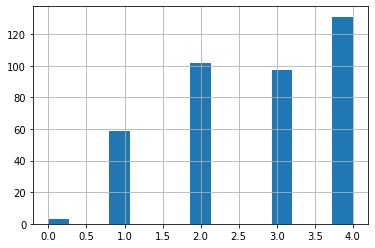

In [15]:
# Образование матери
# 0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее

display(df['Medu'].hist(bins=15))
print(df['Medu'].unique())
print(df['Medu'].value_counts(normalize=True))
df['Medu'].isnull().sum()

С данными все ок, выбросов нет. Распределение нормальное

[ 4.  1.  2.  3. 40. nan  0.]
2.0     0.285714
3.0     0.258760
4.0     0.237197
1.0     0.210243
0.0     0.005391
40.0    0.002695
Name: Fedu, dtype: float64


24

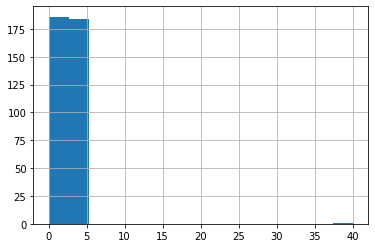

In [16]:
# Образование отца 
# (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

display(df['Fedu'].hist(bins=15))
print(df['Fedu'].unique())
print(df['Fedu'].value_counts(normalize=True))
df['Fedu'].isnull().sum()

In [17]:
# И вот тут мы впервые встречаемся с выбросом! Скорее всего кто-то просто ошибся и приписал ноль, поэтому просто
# пройдемся по столбцу и уберем ноль там, где он не нужен

df['Fedu'] = df['Fedu'].apply(lambda x: x/10 if x >10 else x)

[ 4.  1.  2.  3. nan  0.]
2.0    0.285714
3.0    0.258760
4.0    0.239892
1.0    0.210243
0.0    0.005391
Name: Fedu, dtype: float64


24

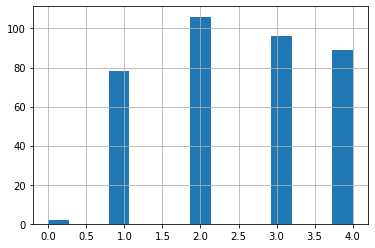

In [18]:
display(df['Fedu'].hist(bins=15))
print(df['Fedu'].unique())
print(df['Fedu'].value_counts(normalize=True))
df['Fedu'].isnull().sum()

Теперь стало ок!

['at_home' 'health' 'other' 'services' 'teacher' nan]
other       0.353723
services    0.260638
at_home     0.154255
teacher     0.146277
health      0.085106
Name: Mjob, dtype: float64


19

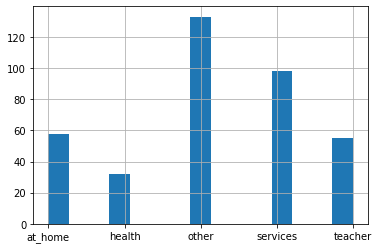

In [19]:
# Работа матери 
# 'teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 
# 'other' - другое

display(df['Mjob'].hist(bins=15))
print(df['Mjob'].unique())
print(df['Mjob'].value_counts(normalize=True))
df['Mjob'].isnull().sum()

Тут все ок. Все значения единообразны, есть некоторое количество пропусков.

['teacher' 'other' nan 'health' 'services' 'at_home']
other       0.548747
services    0.284123
teacher     0.080780
at_home     0.044568
health      0.041783
Name: Fjob, dtype: float64


36

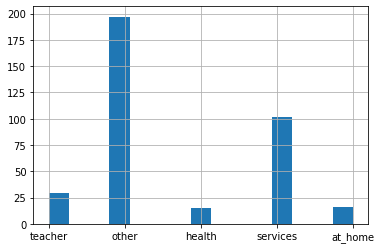

In [20]:
# Работа отца 'teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 
# 'other' - другое

display(df['Fjob'].hist(bins=15))
print(df['Fjob'].unique())
print(df['Fjob'].value_counts(normalize=True))
df['Fjob'].isnull().sum()

Тоже все ок. Значения единообразны, есть несколько пропусков

['course' 'other' 'home' 'reputation' nan]
course        0.362434
home          0.275132
reputation    0.272487
other         0.089947
Name: reason, dtype: float64


17

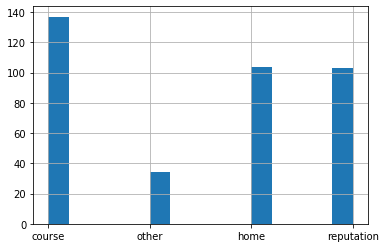

In [21]:
# Причина выбора школы ('home' - близость к дому, 'reputation' - репутация школы, 
# 'course' - образовательная программа, 'other' - другое)

display(df['reason'].hist(bins=15))
print(df['reason'].unique())
print(df['reason'].value_counts(normalize=True))
df['reason'].isnull().sum()

['mother' 'father' 'other' nan]
mother    0.686813
father    0.236264
other     0.076923
Name: guardian, dtype: float64


31

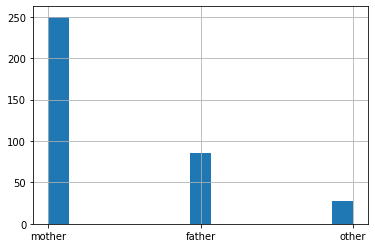

In [22]:
# Опекун ('mother' - мать, 'father' - отец, 'other' - другое)

display(df['guardian'].hist(bins=15))
print(df['guardian'].unique())
print(df['guardian'].value_counts(normalize=True))
df['guardian'].isnull().sum()

[ 2.  1.  3. nan  4.]
1.0    0.659401
2.0    0.261580
3.0    0.059946
4.0    0.019074
Name: traveltime, dtype: float64


28

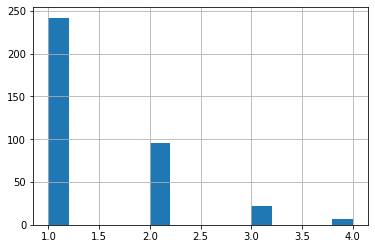

In [23]:
# Время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)

display(df['traveltime'].hist(bins=15))
print(df['traveltime'].unique())
print(df['traveltime'].value_counts(normalize=True))
df['traveltime'].isnull().sum()

Как видим, бОльшая часть учеников живут поблизости от школы

[ 2.  3.  1. nan  4.]
2.0    0.500000
1.0    0.265464
3.0    0.164948
4.0    0.069588
Name: studytime, dtype: float64


7

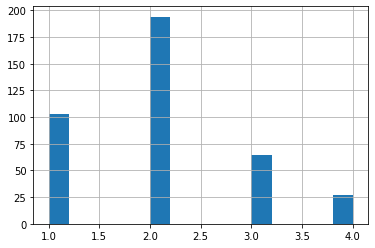

In [24]:
# Время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)

display(df['studytime'].hist(bins=15))
print(df['studytime'].unique())
print(df['studytime'].value_counts(normalize=True))
df['studytime'].isnull().sum()

Очень мало учатся эти щеглы! Но данные нормальные

[ 0.  3. nan  2.  1.]
0.0    0.785523
1.0    0.131367
2.0    0.042895
3.0    0.040214
Name: failures, dtype: float64


22

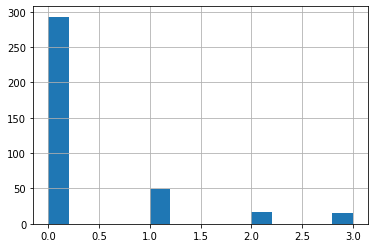

In [25]:
# Количество внеучебных неудач (n, если 1<=n<3, иначе 0)

display(df['failures'].hist(bins=15))
print(df['failures'].unique())
print(df['failures'].value_counts(normalize=True))
df['failures'].isnull().sum()

Понять бы еще, что означает внеучебные неудачи, но в целом с данными все ок

In [26]:
# Дополнительная образовательная поддержка (yes или no)

print(df['schoolsup'].unique())
print(df['schoolsup'].value_counts(normalize=True))
df['schoolsup'].isnull().sum()

['yes' 'no' nan]
no     0.867876
yes    0.132124
Name: schoolsup, dtype: float64


9

In [27]:
# Cемейная образовательная поддержка (yes или no)

print(df['famsup'].unique())
print(df['famsup'].value_counts(normalize=True))
df['famsup'].isnull().sum()

['no' 'yes' nan]
yes    0.615169
no     0.384831
Name: famsup, dtype: float64


39

Так, тут многовато пропусков.

In [28]:
# Дополнительные платные занятия по математике (yes или no)

print(df['paid'].unique())
print(df['paid'].value_counts(normalize=True))
df['paid'].isnull().sum()

['no' nan 'yes']
no     0.56338
yes    0.43662
Name: paid, dtype: float64


40

Распределение почти 50/50. Правда много пропусков

In [29]:
# Дополнительные внеучебные занятия (yes или no)

print(df['activities'].unique())
print(df['activities'].value_counts(normalize=True))
df['activities'].isnull().sum()

['no' 'yes' nan]
yes    0.511811
no     0.488189
Name: activities, dtype: float64


14

In [30]:
# Посещал детский сад (yes или no)

print(df['nursery'].unique())
print(df['nursery'].value_counts(normalize=True))
df['nursery'].isnull().sum()

['yes' 'no' nan]
yes    0.791557
no     0.208443
Name: nursery, dtype: float64


16

[ -6.  -9.  -3.  nan -12.]
-6.0     0.500000
-3.0     0.265464
-9.0     0.164948
-12.0    0.069588
Name: studytime, granular, dtype: float64


7

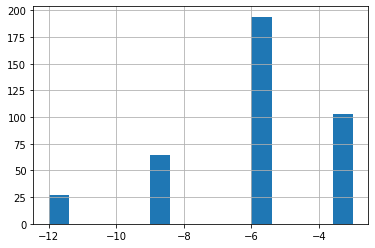

In [31]:
# Обнаруживаем какой-то столбец неясного назначения

display(df['studytime, granular'].hist(bins=15))
print(df['studytime, granular'].unique())
print(df['studytime, granular'].value_counts(normalize=True))
df['studytime, granular'].isnull().sum()

Что это за данные не понятно. Удалять столбец пока не буду, может быть по корреляции удастся понять, что это.

In [32]:
# Хочет получить высшее образование (yes или no)

print(df['higher'].unique())
print(df['higher'].value_counts(normalize=True))
df['higher'].isnull().sum()

['yes' nan 'no']
yes    0.949333
no     0.050667
Name: higher, dtype: float64


20

In [33]:
# Наличие интернета дома (yes или no)

print(df['internet'].unique())
print(df['internet'].value_counts(normalize=True))
df['internet'].isnull().sum()

[nan 'yes' 'no']
yes    0.844875
no     0.155125
Name: internet, dtype: float64


34

In [34]:
# B романтических отношениях (yes или no)

print(df['romantic'].unique())
print(df['romantic'].value_counts(normalize=True))
df['romantic'].isnull().sum()

['no' nan 'yes']
no     0.659341
yes    0.340659
Name: romantic, dtype: float64


31

[ 4.  5.  3. nan -1.  2.  1.]
 4.0    0.494565
 5.0    0.269022
 3.0    0.168478
 2.0    0.046196
 1.0    0.019022
-1.0    0.002717
Name: famrel, dtype: float64


27

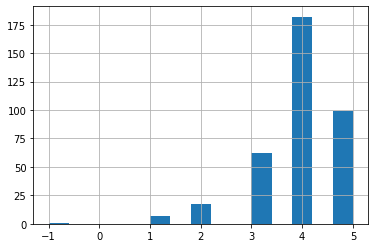

In [35]:
# Cемейные отношения (от 1 - очень плохо до 5 - очень хорошо)

display(df['famrel'].hist(bins=15))
print(df['famrel'].unique())
print(df['famrel'].value_counts(normalize=True))
df['famrel'].isnull().sum()

In [36]:
# Как видим, здесь есть выбросы (отрицательные значения). Избавимся от них

df['famrel'] = df['famrel'].apply(lambda x: x*(-1) if x < 0 else x)

[ 3.  2.  4.  1.  5. nan]
3.0    0.398438
4.0    0.291667
2.0    0.164062
5.0    0.098958
1.0    0.046875
Name: freetime, dtype: float64


11

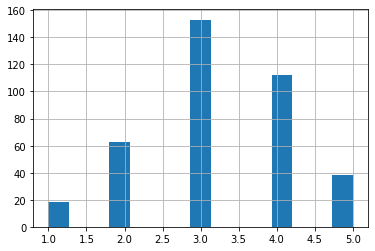

In [37]:
# Cвободное время после школы (от 1 - очень мало до 5 - очень мого)

display(df['freetime'].hist(bins=15))
print(df['freetime'].unique())
print(df['freetime'].value_counts(normalize=True))
df['freetime'].isnull().sum()

[ 4.  3.  2.  1.  5. nan]
3.0    0.328165
2.0    0.260982
4.0    0.217054
5.0    0.134367
1.0    0.059432
Name: goout, dtype: float64


8

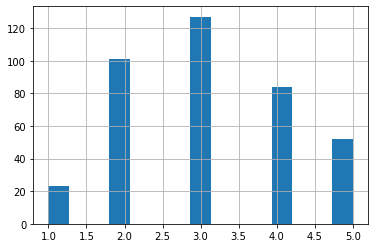

In [38]:
# Проведение времени с друзьями (от 1 - очень мало до 5 - очень много)

display(df['goout'].hist(bins=15))
print(df['goout'].unique())
print(df['goout'].value_counts(normalize=True))
df['goout'].isnull().sum()

[ 3.  5.  1.  2.  4. nan]
5.0    0.363158
3.0    0.234211
4.0    0.165789
1.0    0.123684
2.0    0.113158
Name: health, dtype: float64


15

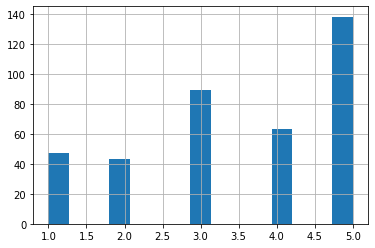

In [39]:
# Tекущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)

display(df['health'].hist(bins=15))
print(df['health'].unique())
print(df['health'].value_counts(normalize=True))
df['health'].isnull().sum()

[  6.   4.  10.   2.   0.  16.  nan  14.   7.   8.  25.  12.  54.  18.
  26.  20.  56.  24.  28.   5.  13.  15.  22.   3. 385.  21.   1.  75.
  30.  19.   9.  11.  38.  40.  23.  17. 212.]
0.0      111
2.0       60
4.0       53
6.0       31
8.0       21
10.0      17
12.0      12
14.0      12
3.0        8
16.0       7
7.0        6
5.0        5
18.0       5
20.0       4
22.0       3
9.0        3
1.0        3
15.0       2
13.0       2
11.0       2
25.0       1
54.0       1
385.0      1
26.0       1
56.0       1
24.0       1
212.0      1
21.0       1
75.0       1
30.0       1
19.0       1
38.0       1
40.0       1
23.0       1
17.0       1
28.0       1
Name: absences, dtype: int64


12

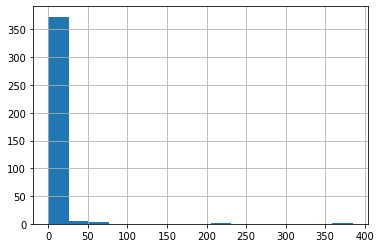

In [40]:
# Количество пропущенных занятий

display(df['absences'].hist(bins=15))
print(df['absences'].unique())
print(df['absences'].value_counts(normalize=False))
df['absences'].isnull().sum()

In [41]:
# Тут видим выбросы - значения, которые явно превышают остальные - 385 и 212. помимо этого есть еще значения 75, 
# 56, 54. Они вроде и похожи на правду, но все равно стоит проверить.

median = df['absences'].median()
IQR = df['absences'].quantile(0.75) - df['absences'].quantile(0.25)
perc25 = df['absences'].quantile(0.25)
perc75 = df['absences'].quantile(0.75)
print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75)
      , "IQR: {}, ".format(IQR),"Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))



25-й перцентиль: 0.0, 75-й перцентиль: 8.0, IQR: 8.0,  Границы выбросов: [-12.0, 20.0].


In [42]:
# Мда.. верхняя граница выброса - 20. Понятно, что всегда найдутся прогульщики, которые могут пропустить и большее
# количество занятий. Поэтому пока не будем удалять эти значения (до 75), а позже посмотрим на распределение
# оценок у этих учеников. А пока удалим все, что больше сотни

df['absences'] = df['absences'].apply(lambda x: x//10 if x>100 else x)

[ 30.  50.  75.  55.  95.  45.  60.  70.  80.  25.  40.  85.  90.  65.
 100.  35.   0.  nan  20.]
50.0     0.138817
55.0     0.118252
0.0      0.095116
75.0     0.084833
65.0     0.079692
40.0     0.079692
60.0     0.079692
70.0     0.069409
45.0     0.069409
80.0     0.041131
30.0     0.038560
90.0     0.030848
35.0     0.023136
25.0     0.017995
85.0     0.015424
95.0     0.012853
100.0    0.002571
20.0     0.002571
Name: score, dtype: float64


6

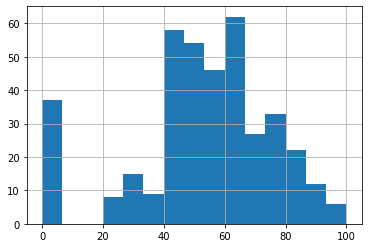

In [43]:
# Баллы по госэкзамену по математике

display(df['score'].hist(bins=15))
print(df['score'].unique())
print(df['score'].value_counts(normalize=True))
df['score'].isnull().sum()

Похоже, что с данными все норм.

In [44]:
# Заменим данные в столбцах, где ответы yes / no

yesno_dict = {'yes':1, 'no':0}
yesno_list = ['schoolsup','famsup','paid','activities','nursery','higher','internet','romantic']

for col in yesno_list:
    df[col] = df[col].map(yesno_dict)

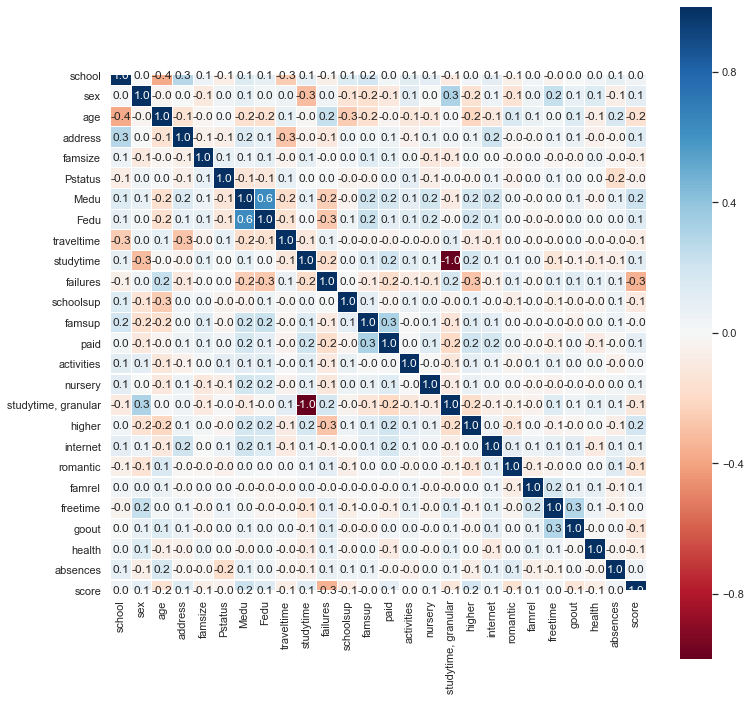

In [45]:
# Теперь посмотрим на корреляцию числовых признаков

sns.set(font_scale=1)
plt.subplots(figsize=(12, 12))
sns.heatmap(df.corr(), square=True,
              annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu")

In [48]:
# Как видим, столбец 'studytime, granular' коррелирует со столбцом 'studytime'. Такие данные нам не нужны
df = df.drop('studytime, granular', axis=1)

# Также видим, что столбцы Medu и Fedu коррелируют между собой. Считаю, что в данном случае можно один столбец
# использовать для заполнения пропусков в другом, а потом удалить его.

df['Medu'] = df['Medu'].fillna(df['Fedu'])
df = df.drop('Fedu', axis=1)

В остальных столбцах корреляции либо отсутствуют, либо незначительны, поэтому не будем их трогать.

In [ ]:
# Теперь посмотрим как столбцы с вещественными данными влияют на score. 

def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y='score', data=df, ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

In [ ]:
# Фактически, столбцов, где вещественных признаков больше 2 у нас всего четыре. Их и исследуем

for col in ['Mjob', 'Fjob', 'reason', 'guardian']:
    get_boxplot(col)

In [ ]:
# Визуально по графикам сложно определить, какой из параметров может оказывать рельное воздействие на финальную
# оценку. Разве что папы, работающие учителями влияют на успеваемость учеников, но в остальном графиками не обойтись
# Поэтому проведем тест Стьюдента

def get_stat_dif(column):
    cols = df.loc[:, column].value_counts().index[:]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], 'score'], 
                        df.loc[df.loc[:, column] == comb[1], 'score']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

In [ ]:
for col in ['Mjob', 'Fjob', 'reason', 'guardian']:
    get_stat_dif(col)

In [ ]:
# Так, видим, что наибольшее влияние на score оказывает работа мам. Значит колнки 'reason', 'guardian' можно удалить
# Колонку 'Fjob' я бы все таки оставил
df = df.drop(['reason', 'guardian'], axis=1)

In [ ]:
df.info()

# Выводы:

Итак, у нас осталось 26 колонок из 30. Две из оставшихся несут в себе категориальные данные, поэтому в дальнейшем их необходимо будет преобразовать думмисами или OneHotEncoder. В целом, данные, на мой взгляд, очень даже качественные (за исключением, наверно, количества пропусков в некоторых колонках, но так как в задании нечего не было сказано про устранение пропусков и обогощение данных, то этот аспект я не принимал во внимание). Выбросы были минимальны, косяков в номинальных данных не было вообще, корреляции среди числовых признаков также минимальны. Данные в числовых признаках в основном имеют нормальное распределение, это нужно учитывать при дальнейшей подготовке данных к построению модели. В итоге удаления колонок по причине бесполезности также были минимальны. БОльшую часть признаков можно использовать для дальнейшего построения модели.